In [1]:
# Downloading all necessary packages

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import torchvision
from torchvision import transforms

from tqdm import trange

from random import normalvariate

import sys
import copy


In [2]:
# Downloading memristive weights and standard deviations from experimental data
samples_weights_txt = ['weights_10', 'weights_100', 'weights_200']
samples_std_txt = ['standard_deviation_10', 'standard_deviation_100', 'standard_deviation_200']
sigma_mu_txt = ['sigma_mu_10', 'sigma_mu_100', 'sigma_mu_200']
samples = {}

for weight_txt,std_txt in zip(samples_weights_txt, samples_std_txt):

    file1 = open(weight_txt + '.txt')
    content = file1.readlines()
    memristor_w = np.array([]) 
    for line in content:
        memristor_w = np.append(memristor_w, np.array(float(line)))
    file1.close()
    samples[weight_txt.removesuffix('.txt')] = memristor_w

    file2 = open(std_txt + '.txt')
    content = file2.readlines()
    standard_deviation = np.array([])
    for line in content:
        standard_deviation = np.append(standard_deviation, np.array(float(line)))
    file2.close()
    samples[std_txt.removesuffix('.txt')] = standard_deviation


for weight_txt, std_txt, sm_txt in zip(samples_weights_txt,samples_std_txt, sigma_mu_txt):
    samples[sm_txt] = np.abs(np.divide(samples[std_txt], samples[weight_txt]))  # Calculate coefficient of variation for every resistive state
    if weight_txt == 'weights_10' or weight_txt == 'weights_100': # Choosing how many states we use for the simulation
        samples[weight_txt] = samples[weight_txt][0:20]
        samples[std_txt] = samples[std_txt][0:20]
        samples[sm_txt] = samples[sm_txt][0:20]
    print('Mean coefficient of variation for memristors with',weight_txt,':\n', "{:.4g}".format(np.mean(samples[sm_txt]) * 100),"%\n")
    samples[weight_txt] = samples[weight_txt]*1000000 # Linear scaling to use memristor resistive states as weights in the neural network

Mean coefficient of variation for memristors with weights_10 :
 23.05 %

Mean coefficient of variation for memristors with weights_100 :
 49.73 %

Mean coefficient of variation for memristors with weights_200 :
 49.89 %



In [32]:
# Uploading MNIST

transform = transforms.Compose([
                                transforms.ToTensor(),
                                transforms.Normalize(mean = 0.1307, std = 0.308)
]) 

train_set = torchvision.datasets.MNIST("./data", download=True, transform = transform)
train_size = int(0.9 * len(train_set))
validation_size = len(train_set) - train_size 
train_set, validation_set = torch.utils.data.random_split(train_set, [train_size, validation_size])
test_set = torchvision.datasets.MNIST("./data", download=True, train=False, transform = transform)

batch_size = 100
trainloader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
validationloader = DataLoader(validation_set, batch_size=batch_size, shuffle=False) # Validation set was used for scaling factor and network architecture selection 
testloader = DataLoader(test_set, batch_size=batch_size, shuffle=False) 
classnames = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']

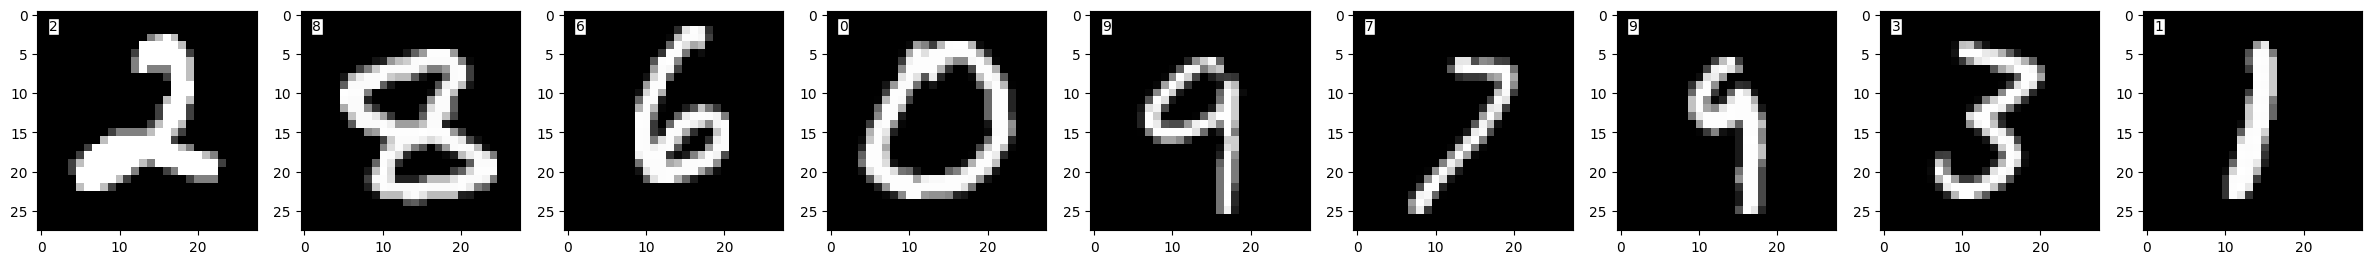

In [33]:
#Visualization of MNIST numbers

fig, ax = plt.subplots(ncols=9, figsize = (30,30))
i=0
for image, labels in (train_set):
  col = i
  i += 1
  ax[col].imshow(image.squeeze(), cmap="gray")
  ax[col].text(1, 2, classnames[labels], bbox={'facecolor': 'white', 'pad': 1})
  if i==9:
    break

In [34]:
# Training network without memristors

def train(model, loss_function, optimizer, epochs):
  accuracy_list = []
  accuracy_list.append(validate(model,validationloader)) 
  train_loss = 0.0
  for _ in trange(epochs):
    for images, labels in trainloader:      
        outputs = model(images)
        loss = loss_function(outputs, labels) 
        loss.backward() 
        optimizer.step()
        optimizer.zero_grad()
        train_loss += loss.item()*images.size(0)   
    train_loss = train_loss/len(trainloader.dataset)
    accuracy_list.append(validate(model,validationloader)) 
  return accuracy_list, loss

def validate(model,someloader):
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in someloader:
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return correct / total

In [35]:
# 2-layer network class

class net(nn.Module):

    def __init__(self):
        super().__init__() 
        self.flat = nn.Flatten(1)
        self.layer1 = nn.Linear (28*28, 512, bias = False)
        self.activ = nn.ReLU()
        self.layer2 = nn.Linear (512, 10, bias = False)

    def forward(self, x):
        x = self.flat(x)
        x = self.layer1(x)
        x = self.activ(x)
        x = self.layer2(x)
        return x
    
def initialize_weights(m):
  for _, layer in m.named_children():
    if isinstance(layer, nn.Linear):
        nn.init.normal_(layer.weight.data, 0, 0.01)

In [36]:
# Function to create a dictionary of memristive weights
def dictionary_of_memristive_weights(memristor_w_scaled):
  memristor_weights = []
  for i in range(len(memristor_w_scaled)):
    for j in range(len(memristor_w_scaled)):
      memristor_weights.append([memristor_w_scaled[i] - memristor_w_scaled[j], i, j])

  def column(matrix, i):
      return [row[i] for row in matrix]

  memristor_weights_and_indexes_list = sorted(memristor_weights)
  memristor_weights_list = column(memristor_weights_and_indexes_list, 0)
  memristor_weights_list = np.array(memristor_weights_list).round(decimals=3)
  np.set_printoptions(threshold=sys.maxsize)
  return(memristor_weights_list, memristor_weights_and_indexes_list)

# Finding best memristors from the dictionary for each weight in the network
def find_best_w(w_ideal, memristor_weights_list, memristor_weights_and_indexes_list, memristor_w_scaled, sigma_mu, variations):
    w_ideal = np.array(w_ideal)
    ind = np.abs(memristor_weights_list - w_ideal).argmin()
    mem1 = memristor_weights_and_indexes_list[ind][1]
    mem2 = memristor_weights_and_indexes_list[ind][2]
    if variations:
      best_w = normalvariate(memristor_w_scaled[mem1], sigma_mu[mem1]*memristor_w_scaled[mem1]) - normalvariate(memristor_w_scaled[mem2], sigma_mu[mem2]*memristor_w_scaled[mem2])
    else:
      best_w = memristor_w_scaled[mem1] - memristor_w_scaled[mem2]
    best_w = best_w.round(decimals=3)
    best_w = torch.FloatTensor([best_w])
    return best_w

# Change weights for model with memristors
def memristive_weights(m, model_ideal, memristor_weights_list, memristor_weights_and_indexes_list, memristor_w_scaled, sigma_mu, variations, e = 0.05, epochs = 1):
  accuracy = []
  for epoch in trange (epochs):
    for name, layer in m.named_children():
      if isinstance(layer, nn.Linear):
        with torch.no_grad():
          if name == 'layer1':
            w_ideal = model_ideal.layer1.weight.data
            w_real = m.layer1.weight.data
          elif name == 'layer2':
            w_ideal = model_ideal.layer2.weight.data
            w_real = m.layer2.weight.data
          for i in range (len(w_ideal)):
            for j in range (len(w_ideal[i])):
              # First epoch - all the weights are changed to memristive
              if epoch == 0:
                w_real[i][j] = find_best_w(w_ideal[i][j], memristor_weights_list, memristor_weights_and_indexes_list, memristor_w_scaled, sigma_mu, variations)
              # All the other epochs - the weights are changed only if they are far from ideal
              elif abs(w_real[i][j] - w_ideal[i][j]) < e:
                pass
              else:
                w_real[i][j] = find_best_w(w_ideal[i][j], memristor_weights_list, memristor_weights_and_indexes_list, memristor_w_scaled, sigma_mu, variations)
          if name == 'layer1':
            m.layer1.weight.data = w_real
          elif name == 'layer2':
            m.layer2.weight.data = w_real
    accuracy.append(validate(m,testloader))
  return accuracy

In [37]:
# Creating dictionaries with possible memristive weights for all devices
memristor_weights_list = {}
memristor_weights_and_indexes_list = {} 
for weight_txt in samples_weights_txt:
    memristor_weights_list[weight_txt], memristor_weights_and_indexes_list[weight_txt] = dictionary_of_memristive_weights(samples[weight_txt])

In [87]:
no_mem = []
mem_std = []
mem_no_std = []
for i in range(5):
    print("Run number", i+1)
    print("Software calculations")
    model_ideal = net()
    initialize_weights(model_ideal)
    optimizer = torch.optim.Adam(model_ideal.parameters(), lr=0.001)
    accuracy, loss = train(model_ideal, nn.CrossEntropyLoss(), optimizer, epochs = 60)  
    no_mem.append(accuracy)    

    for weight_txt, sm_txt in zip(samples_weights_txt, sigma_mu_txt):  
        model = copy.deepcopy(model_ideal)
        print("Off-chip without variations for memristors with", weight_txt)
        mem_no_std.append(memristive_weights(model, model_ideal, memristor_weights_list[weight_txt], 
                                             memristor_weights_and_indexes_list[weight_txt], samples[weight_txt], 
                                             samples[sm_txt], variations = False, e = 0.1, epochs = 1))
        print("Off-chip with variations for memristors with", weight_txt)   
        model = copy.deepcopy(model_ideal)   
        mem_std.append(memristive_weights(model, model_ideal, memristor_weights_list[weight_txt], 
                                          memristor_weights_and_indexes_list[weight_txt], samples[weight_txt], 
                                          samples[sm_txt], variations = True, e = 0.1, epochs = 10))
    print("End of the run number", i+1)

Run number 1
Software calculations


100%|██████████| 60/60 [11:27<00:00, 11.47s/it]


Off-chip without variations for memristors with weights_10


100%|██████████| 1/1 [00:22<00:00, 22.34s/it]


Off-chip with variations for memristors with weights_10


100%|██████████| 10/10 [03:28<00:00, 20.82s/it]


Off-chip without variations for memristors with weights_100


100%|██████████| 1/1 [00:22<00:00, 22.13s/it]


Off-chip with variations for memristors with weights_100


100%|██████████| 10/10 [02:37<00:00, 15.78s/it]


Off-chip without variations for memristors with weights_200


100%|██████████| 1/1 [00:28<00:00, 28.16s/it]


Off-chip with variations for memristors with weights_200


100%|██████████| 10/10 [02:44<00:00, 16.42s/it]


End of the run number 1
Run number 2
Software calculations


100%|██████████| 60/60 [11:31<00:00, 11.52s/it]


Off-chip without variations for memristors with weights_10


100%|██████████| 1/1 [00:21<00:00, 21.96s/it]


Off-chip with variations for memristors with weights_10


100%|██████████| 10/10 [03:24<00:00, 20.44s/it]


Off-chip without variations for memristors with weights_100


100%|██████████| 1/1 [00:21<00:00, 21.86s/it]


Off-chip with variations for memristors with weights_100


100%|██████████| 10/10 [02:40<00:00, 16.01s/it]


Off-chip without variations for memristors with weights_200


100%|██████████| 1/1 [00:28<00:00, 28.72s/it]


Off-chip with variations for memristors with weights_200


100%|██████████| 10/10 [02:41<00:00, 16.17s/it]


End of the run number 2
Run number 3
Software calculations


100%|██████████| 60/60 [10:56<00:00, 10.94s/it]


Off-chip without variations for memristors with weights_10


100%|██████████| 1/1 [00:21<00:00, 21.77s/it]


Off-chip with variations for memristors with weights_10


100%|██████████| 10/10 [03:22<00:00, 20.29s/it]


Off-chip without variations for memristors with weights_100


100%|██████████| 1/1 [00:22<00:00, 22.01s/it]


Off-chip with variations for memristors with weights_100


100%|██████████| 10/10 [02:35<00:00, 15.54s/it]


Off-chip without variations for memristors with weights_200


100%|██████████| 1/1 [00:26<00:00, 26.87s/it]


Off-chip with variations for memristors with weights_200


100%|██████████| 10/10 [02:38<00:00, 15.86s/it]


End of the run number 3
Run number 4
Software calculations


100%|██████████| 60/60 [11:01<00:00, 11.02s/it]


Off-chip without variations for memristors with weights_10


100%|██████████| 1/1 [00:21<00:00, 21.78s/it]


Off-chip with variations for memristors with weights_10


100%|██████████| 10/10 [03:23<00:00, 20.36s/it]


Off-chip without variations for memristors with weights_100


100%|██████████| 1/1 [00:21<00:00, 21.88s/it]


Off-chip with variations for memristors with weights_100


100%|██████████| 10/10 [02:34<00:00, 15.47s/it]


Off-chip without variations for memristors with weights_200


100%|██████████| 1/1 [00:26<00:00, 26.76s/it]


Off-chip with variations for memristors with weights_200


100%|██████████| 10/10 [02:38<00:00, 15.84s/it]


End of the run number 4
Run number 5
Software calculations


100%|██████████| 60/60 [11:08<00:00, 11.15s/it]


Off-chip without variations for memristors with weights_10


100%|██████████| 1/1 [00:21<00:00, 21.90s/it]


Off-chip with variations for memristors with weights_10


100%|██████████| 10/10 [03:24<00:00, 20.43s/it]


Off-chip without variations for memristors with weights_100


100%|██████████| 1/1 [00:21<00:00, 21.82s/it]


Off-chip with variations for memristors with weights_100


100%|██████████| 10/10 [02:40<00:00, 16.02s/it]


Off-chip without variations for memristors with weights_200


100%|██████████| 1/1 [00:28<00:00, 28.31s/it]


Off-chip with variations for memristors with weights_200


100%|██████████| 10/10 [02:41<00:00, 16.14s/it]

End of the run number 5


In [92]:
###### The plots may be slightly different from the ones presented in the paper! ######
###### Due to memristive variations and slight network training differences ######

Mean software accuracy after 60 epochs on validation set is 97.85 %


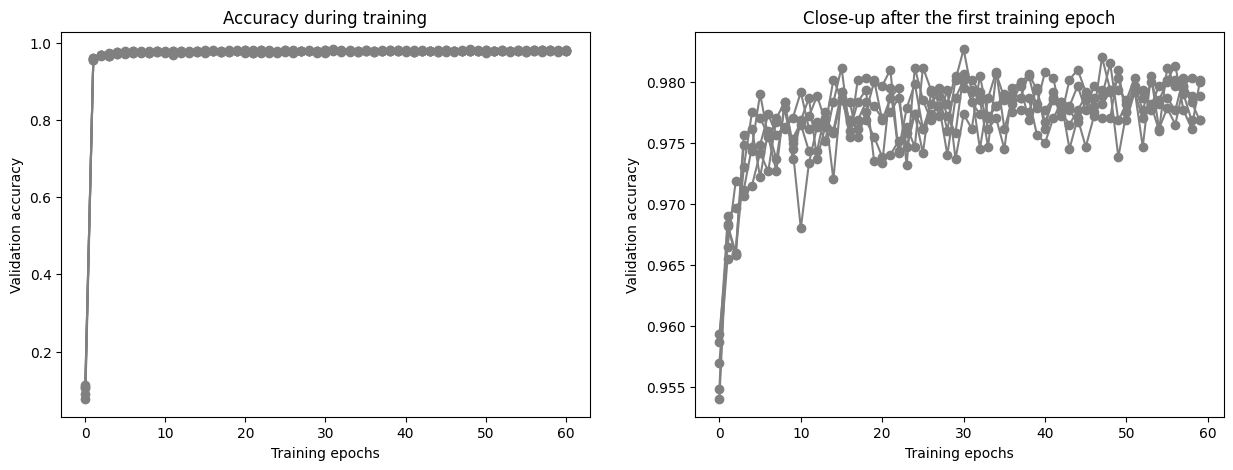

In [93]:
fig, ax = plt.subplots(1,2, figsize=(15, 5))
for i in range(len(no_mem)):
    ax[0].plot(no_mem[i], marker = 'o', color = 'gray')
    ax[1].plot(no_mem[i][1:], marker = 'o', color = 'gray')
ax[0].set_ylabel("Validation accuracy")
ax[0].set_xlabel("Training epochs")
ax[0].title.set_text('Accuracy during training')
ax[1].set_ylabel("Validation accuracy")
ax[1].set_xlabel("Training epochs")
ax[1].title.set_text('Close-up after the first training epoch')
print("Mean software accuracy after 60 epochs on validation set is", "{:.4g}".format(np.mean([no_mem_run[-1] for no_mem_run in no_mem])*100),"%")

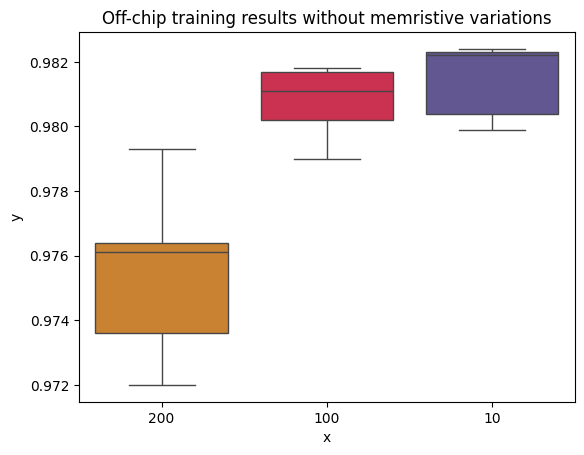

In [94]:
mem_no_std_10=[item[0] for item in mem_no_std[0::3]]
mem_no_std_100=[item[0] for item in mem_no_std[1::3]]
mem_no_std_200=[item[0] for item in mem_no_std[2::3]]
data = [item for sublist in [mem_no_std_200,mem_no_std_100, mem_no_std_10] for item in sublist]
palette = ['#e28319', '#e51842', '#5d4d9b']
data = pd.DataFrame({"x":['200','200','200','200','200','100','100','100','100','100','10','10','10','10','10'], "y":data}) 
sns.boxplot(x = 'x', y = 'y', data=data, palette=palette, hue = 'x', legend = False)
plt.title("Off-chip training results without memristive variations")
plt.show()

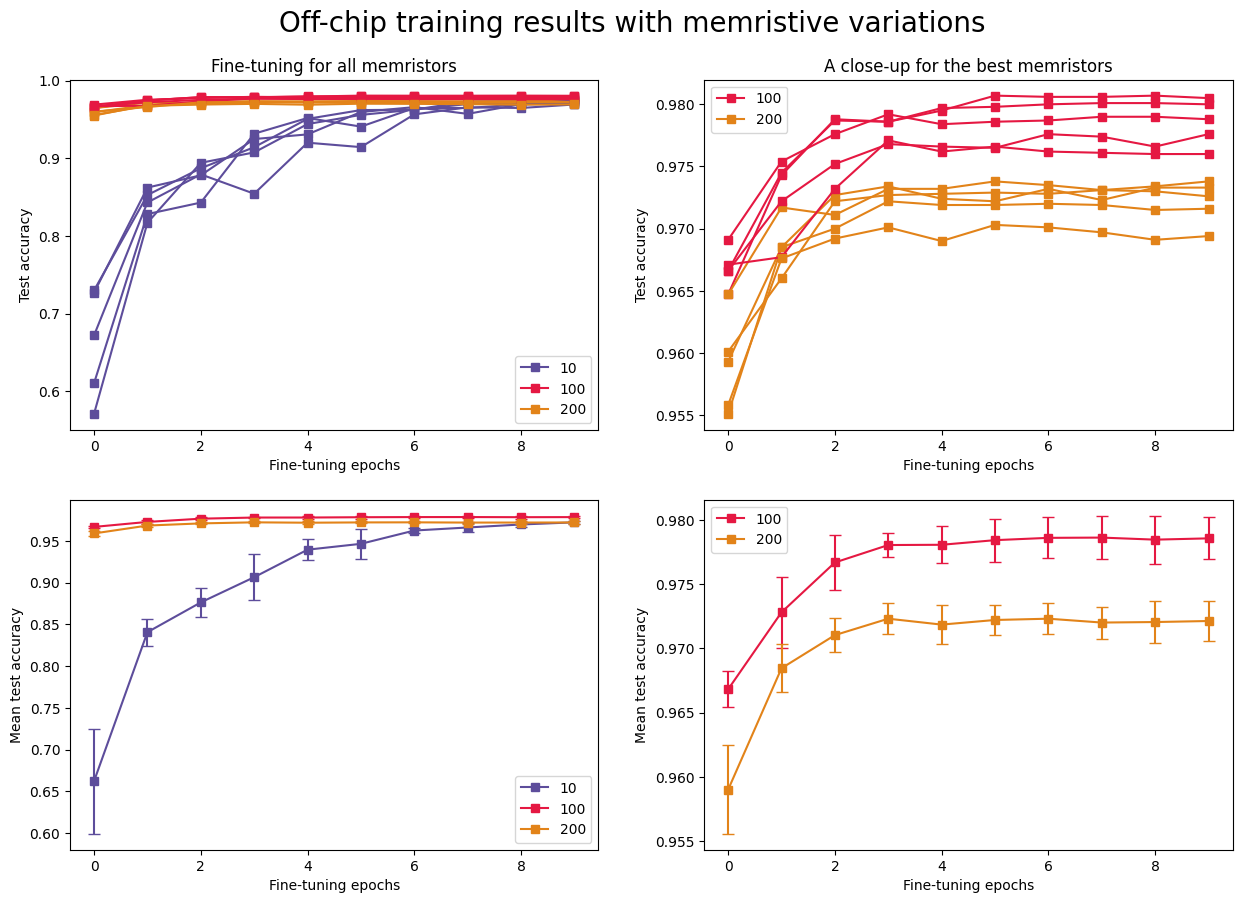

In [95]:
fig, ax = plt.subplots(2,2, figsize=(15, 10))
mem_std_10=[item for item in mem_std[0::3]]
mem_std_100=[item for item in mem_std[1::3]]
mem_std_200=[item for item in mem_std[2::3]]


ax[0][0].plot(mem_std_10[0], marker = 's', color = '#5d4d9b', label  = '10')
ax[0][0].plot(mem_std_100[0], marker = 's', color = '#e51842', label  = '100')
ax[0][0].plot(mem_std_200[0], marker = 's', color = '#e28319', label  = '200')
ax[0][1].plot(mem_std_100[0], marker = 's', color = '#e51842', label  = '100')
ax[0][1].plot(mem_std_200[0], marker = 's', color = '#e28319', label  = '200')
for i in range(1, len(mem_std_10)):
    ax[0][0].plot(mem_std_10[i], marker = 's', color = '#5d4d9b')
    ax[0][0].plot(mem_std_100[i], marker = 's', color = '#e51842')
    ax[0][0].plot(mem_std_200[i], marker = 's', color = '#e28319')
    ax[0][1].plot(mem_std_100[i], marker = 's', color = '#e51842')
    ax[0][1].plot(mem_std_200[i], marker = 's', color = '#e28319')

mean_10 = np.mean(mem_std_10,axis = 0)
mean_100 = np.mean(mem_std_100,axis = 0)
mean_200 = np.mean(mem_std_200,axis = 0)

ax[1][0].plot(mean_10, marker = 's', color = '#5d4d9b', label  = '10')
ax[1][0].errorbar(np.arange(len(mean_10)), mean_10, yerr=np.std(mem_std_10, axis = 0), linestyle='None', color='#5d4d9b', capsize = 4)
ax[1][0].plot(mean_100, marker = 's', color = '#e51842', label  = '100')
ax[1][0].errorbar(np.arange(len(mean_100)), mean_100, yerr=np.std(mem_std_100, axis = 0), linestyle='None', color='#e51842', capsize = 4)
ax[1][0].plot(mean_200, marker = 's', color = '#e28319', label  = '200')
ax[1][0].errorbar(np.arange(len(mean_200)), mean_200, yerr=np.std(mem_std_200, axis = 0), linestyle='None', color='#e28319', capsize = 4)

ax[1][1].plot(mean_100, marker = 's', color = '#e51842', label  = '100')
ax[1][1].errorbar(np.arange(len(mean_100)), mean_100, yerr=np.std(mem_std_100, axis = 0), linestyle='None', color='#e51842', capsize = 4)
ax[1][1].plot(mean_200, marker = 's', color = '#e28319', label  = '200')
ax[1][1].errorbar(np.arange(len(mean_200)), mean_200, yerr=np.std(mem_std_200, axis = 0), linestyle='None', color='#e28319', capsize = 4)

ax[0][0].set_ylabel("Test accuracy")
ax[0][0].set_xlabel("Fine-tuning epochs")
ax[0][0].title.set_text('Fine-tuning for all memristors')
ax[0][0].legend()

ax[0][1].set_ylabel("Test accuracy")
ax[0][1].set_xlabel("Fine-tuning epochs")
ax[0][1].title.set_text('A close-up for the best memristors')
ax[0][1].legend()

ax[1][0].set_ylabel("Mean test accuracy")
ax[1][0].set_xlabel("Fine-tuning epochs")
ax[1][0].legend()

ax[1][1].set_ylabel("Mean test accuracy")
ax[1][1].set_xlabel("Fine-tuning epochs")
ax[1][1].legend()

plt.suptitle("Off-chip training results with memristive variations", x = 0.5, y = 0.95, fontsize = 20)
plt.show()